# Multiscale Analysis of the Sustainable Production of 1,3PDO and 3HP
## Stage 1. Modification of *E. coli* and *S. cerevisiae* metabolic models

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1.0 Preparation

- Loading *E. coli* (iJO1366) and *S. cerevisiae* (iMM904) metabolic models from SBML files
- Storing the models as Python pickles

- Loading the predicted pathways/reactions from Campondonico, 2014
    - data is in MATLAB format.  has to be converted Python pickle.
    - the last three 3HPP producing pathways in the dataset is wrong, this is programmatically corrected.

In [2]:
### Loading the Metabolic Models

from framed.io_utils.sbml import load_sbml_model, CONSTRAINT_BASED
from framed.core.fixes import fix_bigg_model
import cPickle as pickle

# Load iJO1366 model from SBML file
EC_1366_MODEL = 'models/iJO1366.xml'
ec_model = load_sbml_model(EC_1366_MODEL, kind=CONSTRAINT_BASED)
fix_bigg_model(ec_model)
ec_model.id = 'ecoli_iJO1366'
pickle.dump(ec_model, open('models/ecoli_iJO1366.pickle','wb'))

# Load iMM904 model from SBML file
SC_iMM904 = 'models/iMM904_flux.xml'
sc_model = load_sbml_model(SC_iMM904, kind=CONSTRAINT_BASED)
fix_bigg_model(sc_model)
sc_model.id = 'scere'
pickle.dump(sc_model, open('models/scere_iMM904.pickle','wb'))

In [3]:
### Loading Pathways/Reactions from Campodonico, 2014
import scipy.io
from cbmTES.global_constants import *
import cPickle as pickle

campodonico2014_raw = scipy.io.loadmat('models/Campodonico2014_matlab7.mat')
reactions = campodonico2014_raw['react']
pathways = campodonico2014_raw['patwy']

## fix compatibility in reactions (mainly reaction representation scheme)
reactions_ = []
for rxn in reactions:
    r= rxn[0][0].replace('-> ','--> M_').replace('[c]','_c').replace('+ ','+ M_').replace('-L','_L').replace('-D','_D').replace('-R','_R')
    r = 'M_'+ r
    r = r.replace('.', '_')
    reactions_.append(r)
reactions = reactions_

## selecting only the pathways for producing 3HP and 1,3-PDO only
pathways_3HPP = []
pathways_13PDO = []

for p in pathways:
    if p[1] == '3-hydroxypropanoate':
        rxns = p[0][0] - 1 # change to 0-based counting system (MATLAB uses 1-based counting system)
        pathways_3HPP.append(rxns)
    elif p[1] == '1,3-propanediol':
        rxns = p[0][0] - 1 # change to 0-based counting system (MATLAB uses 1-based counting system)
        pathways_13PDO.append(rxns)
        
## fix the error in the dataset (with consultation from the author (Miguel Campodonico))
# add an additional reaction 
reactions.append(u'M_acrac_c + M_h2o_c --> M_3HPP_c')
r_num = len(reactions) - 1
# change reaction 58 to 197 in pathways 22, 23, 24
pathways_3HPP[22][0] = r_num
pathways_3HPP[23][0] = r_num
pathways_3HPP[24][0] = r_num



campodonico2014 = {}
campodonico2014['reactions'] = reactions
campodonico2014['pathways'] = pathways
campodonico2014['pathways_3HPP'] = pathways_3HPP
campodonico2014['pathways_13PDO'] = pathways_13PDO
campodonico2014['metabolites'] = campodonico2014_raw['mets']


pickle.dump(campodonico2014, open('jar/campodonico2014.pickle','wb')) 

## 1.1 Adding Predicted Biosynthetic Pathways to the E. coli Metabolic Model

- Campodonico et al. (2014) have predicted a large number of biosynthetic pathways for both 3HP and 1,3PDO using the GEM-Path algorithm.  
- For our work, we incorporated all these pathways into both *E. coli* (iJO1366)
- This created a "super model" of *E. coli*

In [4]:
### Creating an E. coli "super model"
# The super-model contains all predicted pathways for producing 3HP and 13PDO

from framed.io_utils.plaintext import add_reaction_from_str
from framed.core.models import Metabolite, Reaction
from framed.analysis.simulation import FBA

import cPickle as pickle

model = pickle.load(open('models/ecoli_iJO1366.pickle','rb'))

# loading Campodonico 2014 dataset
campodonico2014 = pickle.load(open('jar/campodonico2014.pickle','rb'))
reactions = campodonico2014['reactions']
pathways_3HPP = campodonico2014['pathways_3HPP']
pathways_13PDO = campodonico2014['pathways_13PDO']

# selecting reactions in viable pathways
rxns = []
for idx_p, p in enumerate(pathways_3HPP):
        for r in p:
            if not (r in rxns):
                rxns.append(int(r))
                
for idx_p, p in enumerate(pathways_13PDO):
        for r in p:
            if not (r in rxns):
                rxns.append(int(r))

# adding biosynthesis reactions
for idx_r, r in enumerate(rxns):  # for each reaction in the pathway
    r_name = 'R_Campodonico_' + str(r)  # reaction name
    r_str = r_name + ": " + reactions[r]
    add_reaction_from_str(model, r_str)

# adding exchange reacitons
add_reaction_from_str(model, 'R_3HPP_tr: M_3HPP_e <-> M_3HPP_c')
add_reaction_from_str(model, 'R_EX_3HPP_e: M_3HPP_e -->') 
add_reaction_from_str(model, 'R_13PDO_tr: M_13PDO_e <-> M_13PDO_c')
add_reaction_from_str(model, 'R_EX_13PDO_e: M_13PDO_e -->') 

pickle.dump(model, open('models/ecoli_super.pickle','wb'))   

print "Modifying the E. coli metabolic model"
print "Number of 3HP producing pathways added: ", len(pathways_3HPP)
print "Number of 1,3PDO producing pathways added: ", len(pathways_13PDO)
print "Total number of biosynthetic reactions added:", len(rxns)


Modifying the E. coli metabolic model
Number of 3HP producing pathways added:  25
Number of 1,3PDO producing pathways added:  41
Total number of biosynthetic reactions added: 58


## 1.2 Evelope Analysis of E. coli super model

Biomass reaction detected: R_Ec_biomass_iJO1366_core_53p95M


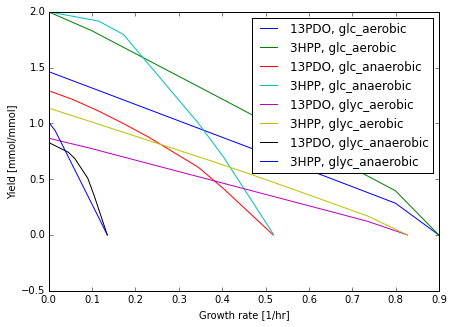

In [5]:
### Testing the Super-Model
# Calculating the 1,3-PDO and 3-HP production envelops for E. coli "super strain" under various conditions
import matplotlib.pyplot as plt
from framed.analysis.variability import production_envelope
from framed.analysis.simulation import FBA
import cPickle as pickle
from cbmTES.global_constants import *
from collections import OrderedDict

# Loading the metabolic models (unpickling)
ecoli_model = pickle.load(open('models/ecoli_super.pickle','rb'))

# set constraints for each environments
glc_aerobic = {r_glc: (-10, 0), r_glyc: (0, 0), r_o2: (-15, None)}    # Ibarra et al. 2002, Feist et al. 2007
glc_anaerobic = {r_glc: (-20, 0), r_glyc: (0, 0), r_o2: (0, None)}    # Feist et al. 2007
glyc_aerobic = {r_glc: (0, 0), r_glyc: (-15, 0), r_o2: (-15, None)}   # Ibarra et al. 2002, Fong et al. 2005, Feist et al. 2007
glyc_anaerobic = {r_glc: (0, 0), r_glyc: (-15, 0), r_o2: (0, None)}   # assumed based on Ibarra et al. 2002, Fong et al. 2005, Feist et al. 2007


# calculate production envelopes
constraints = [glc_aerobic, glc_anaerobic, glyc_aerobic, glyc_anaerobic]
conditions = ['glc_aerobic', 'glc_anaerobic', 'glyc_aerobic', 'glyc_anaerobic']
targets = [r_13PDO, r_3HPP]
growth_rates = OrderedDict()
target_yields = OrderedDict()
target_fluxes = OrderedDict()
active_biosynthetic_pathways = OrderedDict()
active_biosynthetic_fluxes = OrderedDict()

for target in targets:
    for i, condition in enumerate(conditions):
        xvals, ymins, ymaxs = production_envelope(ecoli_model, target, steps=10, constraints=constraints[i])
        growth_rates[target, condition] = xvals
        target_fluxes[target, condition] = ymaxs
        if condition == 'glyc_aerobic' or condition == 'glyc_anaerobic':
            target_yields[target, condition] = [-ymax/constraints[i][r_glyc][0] for ymax in ymaxs]
        else:
            target_yields[target, condition] = [-ymax/constraints[i][r_glc][0] for ymax in ymaxs]
        
        # evaluating which biosynthetic pathways are active for each condition
        active_biosynthetic_pathways[target, condition] = []
        active_biosynthetic_fluxes[target, condition] = []
        for ymax in ymaxs:
            _constraints = constraints[i]
            _constraints[target] = [ymax, ymax]
            PW = []
            PWfluxes = []
            solution = FBA(ecoli_model, constraints=_constraints)
            for s in solution.values.keys():
                if 'R_Campodonico' in s and solution.values[s]>0:
                    PW.append(s)
                    PWfluxes.append(solution.values[s])
            active_biosynthetic_pathways[target, condition].append(PW)
            active_biosynthetic_fluxes[target, condition].append(PWfluxes)
            
# plotting production envelops
plt.figure(dpi=300, figsize = (7, 5))
plt.hold(True)
legends = []

for condition in conditions:
    for target in targets:
        plt.plot(growth_rates[target, condition], target_yields[target, condition])
        legends.append(target.lstrip('R_EX_').rstrip('_e') + ', ' + condition)
        
plt.xlabel('Growth rate [1/hr]')
plt.ylabel('Yield [mmol/mmol]')

legends = tuple(legends)
plt.legend(legends)

plt.show()

In [6]:
# show which biosyntehtic reactoins are active under each conditions
# Evaluating the specific bioreactor(s) used for each scenario
import csv
ofile  = open('results/ecoli_active_pathways.csv', "wb")
writer = csv.writer(ofile, delimiter='|')
 
for condition in active_biosynthetic_pathways.keys():
    print condition
    active_rxns_collections = []
    for idx_s, strains in enumerate(active_biosynthetic_pathways[condition]):
        rxns = active_biosynthetic_pathways[condition][idx_s]
        fluxes = active_biosynthetic_fluxes[condition][idx_s]
        active_rxns = []
        print "growth rate: ", growth_rates[condition][idx_s]
        for idx_r, r in enumerate(rxns):
            r_num = int(r.replace('R_Campodonico_',''))
            #print 'reactions ', r_num,': ', fluxes[idx_r]
            active_rxns.append(r_num)
        print active_rxns
        active_rxns_collections.append(active_rxns)

    row1 = [condition[0],condition[1]]
    row2 = []
    for mu in growth_rates[condition]:
        row2.append(str(round(float(mu),2)))

    row3 = []
    for r_list in active_rxns_collections:
#         row3.append(r_list)
        r_list_row = []
        for rx in r_list:
            r_list_row.append('E'+str(rx))
        row3.append(r_list_row)
        
    writer.writerow(row1)
    writer.writerow(row2)
    writer.writerow(row3)

pickle.dump(growth_rates, open('jar/ecoli_growth_rates.pickle','wb'))  
pickle.dump(active_biosynthetic_pathways, open('jar/ecoli_activepathways.pickle','wb'))  

('R_EX_13PDO_e', 'glc_aerobic')
growth rate:  0.0
[47, 50, 125, 126, 127, 128]
growth rate:  0.0999133606421
[47, 50, 64, 123, 124, 125, 126, 127]
growth rate:  0.199826721284
[47, 50, 64, 123, 124, 125, 126, 127]
growth rate:  0.299740081926
[47, 50, 64, 123, 124, 125, 126, 127]
growth rate:  0.399653442568
[47, 50, 64, 123, 124, 125, 126, 127]
growth rate:  0.499566803211
[47, 50, 64, 123, 124, 125, 126, 127]
growth rate:  0.599480163853
[47, 50, 64, 123, 124, 125, 126, 127]
growth rate:  0.699393524495
[47, 50, 64, 123, 124, 125, 126, 127]
growth rate:  0.799306885137
[50, 64, 123, 124, 125, 126, 127]
growth rate:  0.899220245779
[64]
('R_EX_13PDO_e', 'glc_anaerobic')
growth rate:  0.0
[47, 123, 124, 125, 126, 127]
growth rate:  0.0575359904779
[47, 58, 3, 4, 64, 123, 124, 125, 126, 127]
growth rate:  0.115071980956
[47, 56, 58, 3, 4, 64, 123, 124, 125, 126, 127]
growth rate:  0.172607971434
[47, 56, 58, 3, 4, 64, 123, 124, 125, 126, 127]
growth rate:  0.230143961912
[56, 58, 3, 4, 

## 1.3 Adding Predicted Biosynthetic Pathways to the S.cerevisiae Metabolic Model
- Campodonico et al. (2014) have predicted a large number of biosynthetic pathways for both 3HP and 1,3PDO using the GEM-Path algorithm. 
- These pathways were predicted for *E. coli*, the majority of them are functional with *S. cerevisiae* as well
- We tested the functionality of these predicted pathways using the *S. cerevisiae* model (iMM904)
- We incorporated all the pathways that are functional into the model (iMM904)

In [7]:
### Checking the Viability of the Pathways in S. cerevisiae
from framed.io_utils.plaintext import add_reaction_from_str
from framed.core.models import Metabolite, Reaction
from framed.analysis.simulation import FBA

import cPickle as pickle

# loading Campodonico 2014 dataset
campodonico2014 = pickle.load(open('jar/campodonico2014.pickle','rb'))
reactions = campodonico2014['reactions']
pathways_3HPP = campodonico2014['pathways_3HPP']
pathways_13PDO = campodonico2014['pathways_13PDO']

# checking the viability of 3HP pathways
functionality_3HPP_scere = []
for idx_p, p in enumerate(pathways_3HPP):
    # load E. coli model
    model = pickle.load(open('models/scere_iMM904.pickle','rb'))
    
    # adding biosynthesis reactions
    for idx_r, r in enumerate(p):  # for each reaction in the pathway
        r_name = 'R_P' + str(idx_p) + '_' + str(idx_r)  # reaction name
        r_str = r_name + ": " + reactions[r]
        add_reaction_from_str(model, r_str)
        #print "added reaction: ", r_str

    # adding exchange reacitons
    add_reaction_from_str(model, 'R_3HPP_tr: M_3HPP_e <-> M_3HPP_c')
    add_reaction_from_str(model, 'R_EX_3HPP_e: M_3HPP_e -->') 
    
    
    constraints = {'R_EX_glc_e': (-20, 0), 'R_EX_glyc_e': (-30, 0), 'R_EX_o2_e': (-20, None)}
    
    solution = FBA(model, {'R_EX_3HPP_e':1}, maximize=True, constraints=constraints)
    if solution.fobj > 0:
        functionality_3HPP_scere.append(True)
    else:
        functionality_3HPP_scere.append(False)

# checking the viability of 13PDO pathways
functionality_13PDO_scere = []
for idx_p, p in enumerate(pathways_13PDO):
    # load E. coli model
    model = pickle.load(open('models/ecoli_iJO1366.pickle','rb'))
    
    # adding biosynthesis reactions
    for idx_r, r in enumerate(p):  # for each reaction in the pathway
        r_name = 'R_P' + str(idx_p) + '_' + str(idx_r)  # reaction name
        r_str = r_name + ": " + reactions[r]
        add_reaction_from_str(model, r_str)
        #print "added reaction: ", r_str

    # adding exchange reacitons
    add_reaction_from_str(model, 'R_13PDO_tr: M_13PDO_e <-> M_13PDO_c')
    add_reaction_from_str(model, 'R_EX_13PDO_e: M_13PDO_e -->') 
    
    constraints = {'R_EX_glc_e': (-20, 0), 'R_EX_glyc_e': (-30, 0), 'R_EX_o2_e': (-20, None)}
    
    solution = FBA(model, {'R_EX_13PDO_e':1}, maximize=True, constraints=constraints)
    if solution.fobj > 0:
        functionality_13PDO_scere.append(True)
    else:
        functionality_13PDO_scere.append(False)

    

In [8]:
### Creating an S. cerevisiae "super model"
# The super-model contains all predicted pathways for producing 3HP and 13PDO that are functional in S. cerevisiae

from framed.io_utils.plaintext import add_reaction_from_str
from framed.core.models import Metabolite, Reaction
from framed.analysis.simulation import FBA

import cPickle as pickle
model = pickle.load(open('models/scere_iMM904.pickle','rb'))

# selecting reactions in viable pathways
rxns = []

num_3HPP_pathways = 0
for idx_p, p in enumerate(pathways_3HPP):
    if functionality_3HPP_scere[idx_p] == True:
        num_3HPP_pathways += 1
        for r in p:
            if not (r in rxns):
                rxns.append(int(r))

num_13PDO_pathways = 0              
for idx_p, p in enumerate(pathways_13PDO):
    if functionality_13PDO_scere[idx_p] == True:
        num_13PDO_pathways += 1
        for r in p:
            if not (r in rxns):
                rxns.append(int(r))

# adding biosynthesis reactions
for idx_r, r in enumerate(rxns):  # for each reaction in the pathway
    r_name = 'R_Campodonico_' + str(r)  # reaction name
    r_str = r_name + ": " + reactions[r]
    add_reaction_from_str(model, r_str)

# adding exchange reacitons
add_reaction_from_str(model, 'R_3HPP_tr: M_3HPP_e <-> M_3HPP_c')
add_reaction_from_str(model, 'R_EX_3HPP_e: M_3HPP_e -->') 
add_reaction_from_str(model, 'R_13PDO_tr: M_13PDO_e <-> M_13PDO_c')
add_reaction_from_str(model, 'R_EX_13PDO_e: M_13PDO_e -->') 
        
pickle.dump(model, open('models/scere_super.pickle','wb'))   


print "Modifying the S. cerevisiae metabolic model"
print "Number of 3HP producing pathways added: ", num_3HPP_pathways
print "Number of 1,3PDO producing pathways added: ", num_13PDO_pathways
print "Total number of biosynthetic reactions added:", len(rxns)

Modifying the S. cerevisiae metabolic model
Number of 3HP producing pathways added:  18
Number of 1,3PDO producing pathways added:  41
Total number of biosynthetic reactions added: 49


## 1.4 Envelope Analysis of S. cerevisiae super model

Biomass reaction detected: R_biomass_SC5_notrace


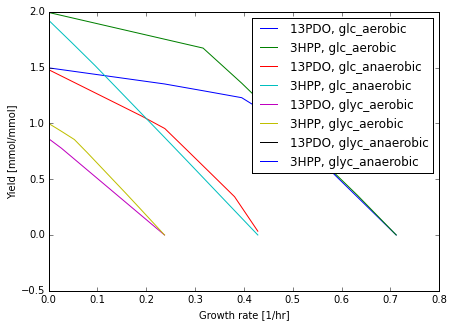

In [9]:
### Testing the Super-Model
# Calculating the 1,3-PDO and 3-HP production envelops for S. cerevisiae "super strain" under various conditions
import matplotlib.pyplot as plt
from framed.analysis.variability import production_envelope
from framed.analysis.simulation import FBA
import cPickle as pickle
from cbmTES.global_constants import *

# Loading the metabolic models (unpickling)
scere_model = pickle.load(open('models/scere_super.pickle','rb'))

# set constraints for each environments
    # a very small oxygen flux is used in anaerobic condition for fatty acid production.  its affect on growth/production is minimal
    # in a real setting, fatty acid would be provided
glc_aerobic = {r_glc: (-20, 0), r_glyc: (0, 0), r_o2: (-8, None)}    # Hjersted et al. 2007
glc_anaerobic = {r_glc: (-20, 0), r_glyc: (0, 0), r_o2: (-0.05, 0)}    # Hjersted et al. 2007
glyc_aerobic = {r_glc: (0, 0), r_glyc: (-4.45, 0), r_o2: (-8, None)}   # Ochoa-Estopier et al. 2011
glyc_anaerobic = {r_glc: (0, 0), r_glyc: (-4.45, 0), r_o2: (0, None)}   # Ochoa-Estopier et al. 2011

# calculate production envelopes
constraints = [glc_aerobic, glc_anaerobic, glyc_aerobic, glyc_anaerobic]
conditions = ['glc_aerobic', 'glc_anaerobic', 'glyc_aerobic', 'glyc_anaerobic']
targets = [r_13PDO, r_3HPP]

growth_rates = OrderedDict()
target_yields = OrderedDict()
target_fluxes = OrderedDict()
active_biosynthetic_pathways = OrderedDict()
active_biosynthetic_fluxes = OrderedDict()


for target in targets:
    for i, condition in enumerate(conditions):
        xvals, ymins, ymaxs = production_envelope(scere_model, target, steps=10, constraints=constraints[i])
        growth_rates[target, condition] = xvals
        target_fluxes[target, condition] = ymaxs
        if condition == 'glyc_aerobic' or condition == 'glyc_anaerobic':
            target_yields[target, condition] = [-ymax/constraints[i][r_glyc][0] for ymax in ymaxs]
        else:
            target_yields[target, condition] = [-ymax/constraints[i][r_glc][0] for ymax in ymaxs]
            
        # evaluating which biosynthetic pathways are active for each condition
        active_biosynthetic_pathways[target, condition] = []
        active_biosynthetic_fluxes[target, condition] = []
        for ymax in ymaxs:
            _constraints = constraints[i]
            _constraints[target] = [ymax, ymax]
            PW = []
            PWfluxes = []
            solution = FBA(scere_model, constraints=_constraints)
            for s in solution.values.keys():
                if 'R_Campodonico' in s and solution.values[s]>0:
                    PW.append(s)
                    PWfluxes.append(solution.values[s])
            active_biosynthetic_pathways[target, condition].append(PW)
            active_biosynthetic_fluxes[target, condition].append(PWfluxes)

# plotting production envelops
plt.figure(dpi=300, figsize = (7, 5))
plt.hold(True)
legends = []

for condition in conditions:
    for target in targets:
        plt.plot(growth_rates[target, condition], target_yields[target, condition])
        legends.append(target.lstrip('R_EX_').rstrip('_e') + ', ' + condition)
        
plt.xlabel('Growth rate [1/hr]')
plt.ylabel('Yield [mmol/mmol]')

legends = tuple(legends)
plt.legend(legends)
plt.show()


In [13]:
# show which biosyntehtic reactoins are active under each conditions
# Evaluating the specific bioreactor(s) used for each scenario
import csv
ofile  = open('results/scere_active_pathways.csv', "wb")
writer = csv.writer(ofile, delimiter='|')
 
for condition in active_biosynthetic_pathways.keys():
    print condition
    active_rxns_collections = []
    for idx_s, strains in enumerate(active_biosynthetic_pathways[condition]):
        rxns = active_biosynthetic_pathways[condition][idx_s]
        fluxes = active_biosynthetic_fluxes[condition][idx_s]
        active_rxns = []
        print "growth rate: ", growth_rates[condition][idx_s]
        for idx_r, r in enumerate(rxns):
            r_num = int(r.replace('R_Campodonico_',''))
            #print 'reactions ', r_num,': ', fluxes[idx_r]
            active_rxns.append(r_num)
        print active_rxns
        active_rxns_collections.append(active_rxns)

    row1 = [condition[0],condition[1]]
    row2 = []
    for mu in growth_rates[condition]:
        row2.append(str(round(float(mu),2)))

    row3 = []
    for r_list in active_rxns_collections:
        r_list_row = []
        for rx in r_list:
            r_list_row.append('S'+str(rx))
        row3.append(r_list_row)
    
    writer.writerow(row1)
    writer.writerow(row2)
    writer.writerow(row3)



pickle.dump(growth_rates, open('jar/scere_growth_rates.pickle','wb'))  
pickle.dump(active_biosynthetic_pathways, open('jar/scere_activepathways.pickle','wb'))  

('R_EX_13PDO_e', 'glc_aerobic')
growth rate:  0.0
[51, 118, 127, 129]
growth rate:  0.079105583542
[51, 118, 127, 129]
growth rate:  0.158211167084
[50, 51, 118, 127, 129]
growth rate:  0.237316750626
[50, 51, 118, 127, 129]
growth rate:  0.316422334168
[50, 51, 118, 127, 129]
growth rate:  0.39552791771
[50, 51, 118, 127, 129]
growth rate:  0.474633501252
[50, 51, 55, 118, 127, 129]
growth rate:  0.553739084794
[50, 51, 55, 118, 127, 129]
growth rate:  0.632844668336
[50, 51, 55, 118, 127, 129]
growth rate:  0.711950251878
[54, 55]
('R_EX_13PDO_e', 'glc_anaerobic')
growth rate:  0.0
[51, 125, 126, 127]
growth rate:  0.0476134220636
[45, 51, 125, 126, 127]
growth rate:  0.0952268441271
[45, 51, 125, 126, 127]
growth rate:  0.142840266191
[45, 51, 125, 126, 127]
growth rate:  0.190453688254
[45, 51, 125, 126, 127]
growth rate:  0.238067110318
[45, 51, 55, 125, 126, 127]
growth rate:  0.285680532381
[45, 51, 55, 125, 126, 127]
growth rate:  0.333293954445
[45, 51, 55, 125, 126, 127]
grow

In [11]:
r_list

[53, 118]

In [12]:
r_list_row = []
for rx in r_list:
    r_list_row.append('E'+str(rx))
print r_list_row    

['E53', 'E118']
